In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv

In [2]:
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [3]:
#!wget https://universe.roboflow.com/ds/J2gwc4lbUt?key=EDrj9yWOXp -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset2/"

In [4]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset1/"

## Setup

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import datetime

import keras_cv

/tmp/ipykernel_25291/2071641442.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/andrea/tfenvl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-22 14:27:38.298823: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable 

Using TensorFlow backend


In [6]:
# per bypassare messaggi di warning relativi all'implementazione dei layer di Data-Augmentation
tf.get_logger().setLevel('ERROR')

# impostazione per TensorFlow in modo che non allochi tutta
# la memoria della GPU ma solo quella necessaria, in modo da
# poter lanciare altri addestramenti in parallelo a questo
#physical_devices = tf.config.list_physical_devices('GPU')
#for pd in physical_devices:
#    try:
#      tf.config.experimental.set_memory_growth(pd, True)
#    except:
#      # device non valida/compatibile
#      pass

## Hyperparameters

In [7]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.001 #1.0000001e-05
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

BACKBONE_SIZE = "xs"
BACKBONE_NAME ="yolo_v8_" + BACKBONE_SIZE + "_backbone_coco"
BACKBONE_TRAINABLE = False

MODEL_NAME = "model-{size}{freezed}".format(size=BACKBONE_SIZE, freezed= "-bbfreez" if BACKBONE_TRAINABLE == False else "")
HISTORY_NAME = MODEL_NAME + "-history"

# Path to images and annotations
path_train = "../dataset1/train/"
path_valid = "../dataset1/valid/"

# elements to use for debug callbacks (use 0 in real train process)
debug_size_train = 0
debug_size_valid = debug_size_train * SPLIT_RATIO

class_ids = [
    "TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    #"emptychair", "fullchair"
]

In [8]:
import numpy as np
a= np.array(class_ids)
print(a.shape)

(12,)


In [9]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def GetDataFiles(path) :
# Get all XML file paths in path_annot and sort them
    xml_files = sorted(
        [
            os.path.join(path, file_name)
            for file_name in os.listdir(path)
            if file_name.endswith(".xml")
        ]
    )

    # Get all JPEG image file paths in path_images and sort them
    #jpg_files = sorted(
    #    [
    #        os.path.join(path, file_name)
    #        for file_name in os.listdir(path)
    #        if file_name.endswith(".jpg")
    #    ]
    #)
    return xml_files

In [10]:

def parse_annotation(xml_file, path_images):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

def create_object_arrays(xml_files, path, num_examples=0) :
    image_paths = []
    bbox = []
    classes = []
    i = 0
    for xml_file in tqdm(xml_files):
        i = i+1
        if num_examples > 0 and i > num_examples :
            break            
        image_path, boxes, class_ids = parse_annotation(xml_file, path)
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

    return image_paths, bbox, classes

In [11]:
def get_data(path, num_examples=0):
    xmls = GetDataFiles(path)
    image_paths, bbox, classes = create_object_arrays(xmls, path, num_examples)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    return  tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [12]:
train_data = get_data(path_train, debug_size_train)

100%|██████████| 4660/4660 [00:01<00:00, 4069.48it/s]
2024-02-22 14:27:44.537257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 14:27:44.657924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 14:27:44.657969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 14:27:44.662067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 14:

In [13]:
val_data = get_data(path_valid, debug_size_valid)

100%|██████████| 486/486 [00:00<00:00, 3065.08it/s]


In [14]:
# Split the dataset into train and validation sets
#val_data = val_data.take(20)
#train_data = train_data.take(100)

In [15]:
print(train_data.__len__())
print(val_data.__len__())

tf.Tensor(4660, shape=(), dtype=int64)
tf.Tensor(486, shape=(), dtype=int64)


In [16]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [17]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [18]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [19]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
# s = tf.zeros((1, 4)).shape
# for x in train_ds.take(4780):  
#     if x["bounding_boxes"]["boxes"].shape == tf.shape(4, None, 4).shape:
#         bboxes = x["bounding_boxes"]["boxes"]
#         #print(type(bboxes))
#         for y in bboxes:
#             if s != y.shape :
#                 print(y)
    
    #print(x["images"])

    #numpy_images = images.numpy()
    #numpy_bounding_boxes = bounding_boxes.numpy()
    #print(numpy_images)
    #print(numpy_bounding_boxes)

#x = list(train_ds.as_numpy_iterator())
#print(x["images"])

#x, = train_ds.take(1)
#print(x["bounding_boxes"])
#print(x["bounding_boxes"]["boxes"].shape)

## Check Dataset

In [21]:
def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [22]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    BACKBONE_NAME,  # We will use yolov8 small backbone with coco weights
    trainable = BACKBONE_TRAINABLE
)

/home/andrea/tfenvl/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/tfenvl/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [23]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    #fpn_depth=1
)
#yolo.summary()

In [24]:
#for layer in yolo.layers:
#    if "yolo_v8_head" in layer.name:
#        #print(layer.name + " - " + str(layer.trainable))
#        layer.trainable = True
#    else:
#        layer.trainable = False
#        
#yolo.summary()

## Compile the Model

In [25]:
#yolo.load_weights(MODEL_NAME + ".h5")

In [26]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
#yolo.summary()

In [27]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(        
            bounding_box_format="xyxy",
            evaluate_freq=1 #1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0
        #self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        example = self.data.shuffle(BATCH_SIZE).take(10)
        for batch in example:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            #y_pred = tf.RaggedTensor.from_tensor(y_pred)
            #newb = y_true["boxes"]
            #for b in newb:
            #    b = tf.RaggedTensor.from_tensor(b)
            #y_true["boxes"] = newb
            #y_true["boxes"] = tf.reshape(y_true["boxes"], [-1])
            #y_pred["boxes"] = tf.reshape(y_pred["boxes"], [-1])
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = logs["MaP"]
        #current_map = logs["val_loss"]
        if current_map > self.best_map:
            self.best_map = current_map

        now = datetime.datetime.now()
        #self.model.save(self.save_path + "-test"+ now.strftime("-%m%d%Y-%H%M%S") + ".h5")
        self.model.save(self.save_path + ".h5")

        return logs


In [28]:
#yolo.save("model_3ep.h5")

In [29]:
# path per i log di TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

## Train the Model

In [30]:
# definizione di due callback per migliorare l'addestramento
early_stopping = keras.callbacks.EarlyStopping(monitor="MaP", patience=10, mode='max')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="MaP", patience=5, mode='max')

#coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
#    val_ds.take(2), bounding_box_format="xyxy"
#)

history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, reduce_lr]#, early_stopping]
)

2024-02-22 14:27:56.011590: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/50


2024-02-22 14:28:17.583821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-22 14:28:22.159331: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-22 14:28:40.108299: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f44fdffdcf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 14:28:40.108359: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-22 14:28:40.150820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708608520.289071   25441 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2330/2330 [==============================] - ETA: 0s - loss: 11.8311 - box_loss: 2.6845 - class_loss: 9.1465

2024-02-22 14:34:22.522152: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:34:36.088210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:34:36.110550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 409s 152ms/step - loss: 11.8311 - box_loss: 2.6845 - class_loss: 9.1465 - val_loss: 3.4450 - val_box_loss: 3.0425 - val_class_loss: 0.4025 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 0.0010
Epoch 2/50
   1/2330 [..............................] - ETA: 17:24 - loss: 2.9926 - box_loss: 2.5877 - class_loss: 0.4050

2024-02-22 14:34:46.645671: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.8559 - box_loss: 2.5325 - class_loss: 0.3234

2024-02-22 14:40:18.482891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:40:29.056528: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:40:29.058762: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 346s 148ms/step - loss: 2.8559 - box_loss: 2.5325 - class_loss: 0.3234 - val_loss: 3.0144 - val_box_loss: 2.6068 - val_class_loss: 0.4076 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 0.0010
Epoch 3/50


2024-02-22 14:40:33.384305: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.7230 - box_loss: 2.4258 - class_loss: 0.2972

2024-02-22 14:46:03.474250: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:46:13.695776: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - 344s 148ms/step - loss: 2.7230 - box_loss: 2.4258 - class_loss: 0.2972 - val_loss: 3.0812 - val_box_loss: 2.6725 - val_class_loss: 0.4087 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 0.0010
Epoch 4/50


2024-02-22 14:46:18.019643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.5465 - box_loss: 2.2657 - class_loss: 0.2808

2024-02-22 14:51:48.779050: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:51:59.127093: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:51:59.127996: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 345s 148ms/step - loss: 2.5465 - box_loss: 2.2657 - class_loss: 0.2808 - val_loss: 3.0651 - val_box_loss: 2.6596 - val_class_loss: 0.4055 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 0.0010
Epoch 5/50


2024-02-22 14:52:03.495902: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.4747 - box_loss: 2.2006 - class_loss: 0.2740

2024-02-22 14:57:42.947810: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:57:53.319087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 14:57:53.324502: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 354s 152ms/step - loss: 2.4747 - box_loss: 2.2006 - class_loss: 0.2740 - val_loss: 2.9355 - val_box_loss: 2.5628 - val_class_loss: 0.3727 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 0.0010
Epoch 6/50


2024-02-22 14:57:57.654664: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.3904 - box_loss: 2.1231 - class_loss: 0.2673

2024-02-22 15:03:35.951186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:03:46.328112: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:03:46.328282: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 353s 151ms/step - loss: 2.3904 - box_loss: 2.1231 - class_loss: 0.2673 - val_loss: 2.8160 - val_box_loss: 2.4394 - val_class_loss: 0.3766 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 0.0010
Epoch 7/50
   1/2330 [..............................] - ETA: 17:56 - loss: 2.2648 - box_loss: 1.9362 - class_loss: 0.3285

2024-02-22 15:03:50.694105: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.3772 - box_loss: 2.0863 - class_loss: 0.2909

2024-02-22 15:09:27.215201: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:09:37.573693: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:09:37.573911: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 351s 150ms/step - loss: 2.3772 - box_loss: 2.0863 - class_loss: 0.2909 - val_loss: 2.6358 - val_box_loss: 2.3178 - val_class_loss: 0.3181 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-04
Epoch 8/50
   1/2330 [..............................] - ETA: 16:56 - loss: 2.7227 - box_loss: 2.4618 - class_loss: 0.2609

2024-02-22 15:09:41.819830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2979 - box_loss: 2.0180 - class_loss: 0.2799

2024-02-22 15:15:19.307925: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:15:29.666046: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:15:29.666224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 352s 151ms/step - loss: 2.2979 - box_loss: 2.0180 - class_loss: 0.2799 - val_loss: 2.5598 - val_box_loss: 2.2386 - val_class_loss: 0.3213 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-04
Epoch 9/50
   1/2330 [..............................] - ETA: 17:59 - loss: 2.3435 - box_loss: 2.0858 - class_loss: 0.2576

2024-02-22 15:15:33.945083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2909 - box_loss: 2.0131 - class_loss: 0.2778

2024-02-22 15:21:08.723448: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:21:19.111685: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:21:19.113265: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 349s 150ms/step - loss: 2.2909 - box_loss: 2.0131 - class_loss: 0.2778 - val_loss: 2.5452 - val_box_loss: 2.2263 - val_class_loss: 0.3189 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-04
Epoch 10/50


2024-02-22 15:21:23.475395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2658 - box_loss: 1.9906 - class_loss: 0.2751

2024-02-22 15:26:57.239315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:27:07.562957: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:27:07.564210: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 348s 149ms/step - loss: 2.2658 - box_loss: 1.9906 - class_loss: 0.2751 - val_loss: 2.5429 - val_box_loss: 2.2254 - val_class_loss: 0.3176 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-04
Epoch 11/50
   1/2330 [..............................] - ETA: 18:19 - loss: 2.3259 - box_loss: 2.0911 - class_loss: 0.2348

2024-02-22 15:27:11.864515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2644 - box_loss: 1.9916 - class_loss: 0.2728

2024-02-22 15:32:45.295480: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:32:55.572456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:32:55.581284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 348s 149ms/step - loss: 2.2644 - box_loss: 1.9916 - class_loss: 0.2728 - val_loss: 2.5808 - val_box_loss: 2.2625 - val_class_loss: 0.3183 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-04
Epoch 12/50
   1/2330 [..............................] - ETA: 17:10 - loss: 2.1383 - box_loss: 1.8963 - class_loss: 0.2420

2024-02-22 15:32:59.827195: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2737 - box_loss: 1.9831 - class_loss: 0.2906

2024-02-22 15:38:32.594147: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - 347s 149ms/step - loss: 2.2737 - box_loss: 1.9831 - class_loss: 0.2906 - val_loss: 2.5758 - val_box_loss: 2.2690 - val_class_loss: 0.3068 - MaP: 0.0112 - MaP@[IoU=50]: 0.0281 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0112 - Recall@[max_detections=1]: 0.0667 - Recall@[max_detections=10]: 0.0667 - Recall@[max_detections=100]: 0.0667 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0667 - lr: 1.0000e-05
Epoch 13/50
   1/2330 [..............................] - ETA: 21:20 - loss: 2.3773 - box_loss: 2.1422 - class_loss: 0.2351

2024-02-22 15:38:47.225578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2676 - box_loss: 1.9812 - class_loss: 0.2864

2024-02-22 15:44:20.598482: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:44:30.911258: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:44:30.911427: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 348s 149ms/step - loss: 2.2676 - box_loss: 1.9812 - class_loss: 0.2864 - val_loss: 2.5423 - val_box_loss: 2.2410 - val_class_loss: 0.3013 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-05
Epoch 14/50


2024-02-22 15:44:35.239812: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2615 - box_loss: 1.9788 - class_loss: 0.2827

2024-02-22 15:50:07.227515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:50:17.370721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:50:17.370851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 346s 148ms/step - loss: 2.2615 - box_loss: 1.9788 - class_loss: 0.2827 - val_loss: 2.5617 - val_box_loss: 2.2612 - val_class_loss: 0.3005 - MaP: 0.0033 - MaP@[IoU=50]: 0.0333 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0042 - Recall@[max_detections=1]: 0.0200 - Recall@[max_detections=10]: 0.0200 - Recall@[max_detections=100]: 0.0200 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0250 - lr: 1.0000e-05
Epoch 15/50
   1/2330 [..............................] - ETA: 17:45 - loss: 1.6305 - box_loss: 1.4395 - class_loss: 0.1910

2024-02-22 15:50:21.671101: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2406 - box_loss: 1.9581 - class_loss: 0.2825

2024-02-22 15:55:53.268169: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:56:03.372379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:56:03.382107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 346s 148ms/step - loss: 2.2406 - box_loss: 1.9581 - class_loss: 0.2825 - val_loss: 2.5341 - val_box_loss: 2.2335 - val_class_loss: 0.3005 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-05
Epoch 16/50
   1/2330 [..............................] - ETA: 16:49 - loss: 2.2572 - box_loss: 2.0420 - class_loss: 0.2152

2024-02-22 15:56:07.586799: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2513 - box_loss: 1.9689 - class_loss: 0.2824

2024-02-22 16:01:50.528666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:01:50.528881: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - 347s 149ms/step - loss: 2.2513 - box_loss: 1.9689 - class_loss: 0.2824 - val_loss: 2.5196 - val_box_loss: 2.2153 - val_class_loss: 0.3043 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-05
Epoch 17/50
   1/2330 [..............................] - ETA: 15:51 - loss: 2.1643 - box_loss: 1.9028 - class_loss: 0.2616

2024-02-22 16:01:54.668037: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2447 - box_loss: 1.9623 - class_loss: 0.2823

2024-02-22 16:07:25.582153: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - 345s 148ms/step - loss: 2.2447 - box_loss: 1.9623 - class_loss: 0.2823 - val_loss: 2.5655 - val_box_loss: 2.2610 - val_class_loss: 0.3046 - MaP: 0.0063 - MaP@[IoU=50]: 0.0312 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0063 - Recall@[max_detections=1]: 0.0500 - Recall@[max_detections=10]: 0.0500 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0500 - lr: 1.0000e-05
Epoch 18/50
   1/2330 [..............................] - ETA: 15:33 - loss: 2.2288 - box_loss: 2.0120 - class_loss: 0.2168

2024-02-22 16:07:39.776144: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2413 - box_loss: 1.9570 - class_loss: 0.2843

2024-02-22 16:13:10.790946: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:13:20.887058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:13:20.887405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 345s 148ms/step - loss: 2.2413 - box_loss: 1.9570 - class_loss: 0.2843 - val_loss: 2.5959 - val_box_loss: 2.2937 - val_class_loss: 0.3022 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-06
Epoch 19/50


2024-02-22 16:13:25.269343: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2607 - box_loss: 1.9766 - class_loss: 0.2842

2024-02-22 16:18:56.009394: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:19:06.092472: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:19:06.096788: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 345s 148ms/step - loss: 2.2607 - box_loss: 1.9766 - class_loss: 0.2842 - val_loss: 2.5511 - val_box_loss: 2.2489 - val_class_loss: 0.3022 - MaP: 0.0067 - MaP@[IoU=50]: 0.0667 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0083 - Recall@[max_detections=1]: 0.0200 - Recall@[max_detections=10]: 0.0200 - Recall@[max_detections=100]: 0.0200 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0250 - lr: 1.0000e-06
Epoch 20/50
   1/2330 [..............................] - ETA: 22:01 - loss: 2.1657 - box_loss: 1.9032 - class_loss: 0.2625

2024-02-22 16:19:10.341185: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2430 - box_loss: 1.9600 - class_loss: 0.2830

2024-02-22 16:24:42.409230: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:24:52.605088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:24:52.605456: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 346s 148ms/step - loss: 2.2430 - box_loss: 1.9600 - class_loss: 0.2830 - val_loss: 2.5529 - val_box_loss: 2.2508 - val_class_loss: 0.3021 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-06
Epoch 21/50


2024-02-22 16:24:56.973616: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2287 - box_loss: 1.9463 - class_loss: 0.2823

2024-02-22 16:30:28.744448: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:30:38.881852: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:30:38.884473: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 346s 148ms/step - loss: 2.2287 - box_loss: 1.9463 - class_loss: 0.2823 - val_loss: 2.5643 - val_box_loss: 2.2634 - val_class_loss: 0.3008 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-06
Epoch 22/50
   1/2330 [..............................] - ETA: 16:41 - loss: 2.2141 - box_loss: 1.9571 - class_loss: 0.2569

2024-02-22 16:30:43.179424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2496 - box_loss: 1.9673 - class_loss: 0.2823

2024-02-22 16:36:12.532362: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:36:22.714686: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:36:22.714866: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 343s 147ms/step - loss: 2.2496 - box_loss: 1.9673 - class_loss: 0.2823 - val_loss: 2.5716 - val_box_loss: 2.2693 - val_class_loss: 0.3023 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-06
Epoch 23/50


2024-02-22 16:37:05.187164: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2538 - box_loss: 1.9713 - class_loss: 0.2824

2024-02-22 16:42:36.231594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:42:46.524378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:42:46.535199: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 345s 148ms/step - loss: 2.2538 - box_loss: 1.9713 - class_loss: 0.2824 - val_loss: 2.5740 - val_box_loss: 2.2715 - val_class_loss: 0.3025 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-07
Epoch 24/50


2024-02-22 16:42:50.832203: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2400 - box_loss: 1.9570 - class_loss: 0.2830

2024-02-22 16:48:25.283204: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:48:35.833941: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:48:35.844914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 349s 150ms/step - loss: 2.2400 - box_loss: 1.9570 - class_loss: 0.2830 - val_loss: 2.5442 - val_box_loss: 2.2433 - val_class_loss: 0.3010 - MaP: 0.0083 - MaP@[IoU=50]: 0.0208 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0083 - Recall@[max_detections=1]: 0.1000 - Recall@[max_detections=10]: 0.1000 - Recall@[max_detections=100]: 0.1000 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.1000 - lr: 1.0000e-07
Epoch 25/50


2024-02-22 16:48:40.220454: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2495 - box_loss: 1.9667 - class_loss: 0.2828

2024-02-22 16:54:15.028844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:54:25.455898: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 16:54:25.456721: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 349s 150ms/step - loss: 2.2495 - box_loss: 1.9667 - class_loss: 0.2828 - val_loss: 2.5568 - val_box_loss: 2.2531 - val_class_loss: 0.3037 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-07
Epoch 26/50


2024-02-22 16:54:30.016038: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2459 - box_loss: 1.9635 - class_loss: 0.2824

2024-02-22 17:00:10.620521: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:00:21.340636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:00:21.340891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 356s 152ms/step - loss: 2.2459 - box_loss: 1.9635 - class_loss: 0.2824 - val_loss: 2.5320 - val_box_loss: 2.2272 - val_class_loss: 0.3048 - MaP: 0.0188 - MaP@[IoU=50]: 0.0833 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0188 - Recall@[max_detections=1]: 0.0625 - Recall@[max_detections=10]: 0.0625 - Recall@[max_detections=100]: 0.0625 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0625 - lr: 1.0000e-07
Epoch 27/50


2024-02-22 17:00:26.101284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2486 - box_loss: 1.9660 - class_loss: 0.2826

2024-02-22 17:06:01.485437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:06:11.846759: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:06:11.849149: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 350s 150ms/step - loss: 2.2486 - box_loss: 1.9660 - class_loss: 0.2826 - val_loss: 2.5331 - val_box_loss: 2.2320 - val_class_loss: 0.3011 - MaP: 0.0375 - MaP@[IoU=50]: 0.1250 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0375 - Recall@[max_detections=1]: 0.0750 - Recall@[max_detections=10]: 0.0750 - Recall@[max_detections=100]: 0.0750 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0750 - lr: 1.0000e-07
Epoch 28/50
   1/2330 [..............................] - ETA: 21:37 - loss: 2.4445 - box_loss: 2.2244 - class_loss: 0.2200

2024-02-22 17:06:16.282110: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2421 - box_loss: 1.9597 - class_loss: 0.2825

2024-02-22 17:11:50.202957: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:12:00.531666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:12:00.531891: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 348s 149ms/step - loss: 2.2421 - box_loss: 1.9597 - class_loss: 0.2825 - val_loss: 2.5220 - val_box_loss: 2.2199 - val_class_loss: 0.3021 - MaP: 0.0050 - MaP@[IoU=50]: 0.0500 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0050 - Recall@[max_detections=1]: 0.0250 - Recall@[max_detections=10]: 0.0250 - Recall@[max_detections=100]: 0.0250 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0250 - lr: 1.0000e-07
Epoch 29/50
   1/2330 [..............................] - ETA: 16:45 - loss: 2.2743 - box_loss: 2.0372 - class_loss: 0.2371

2024-02-22 17:12:04.796583: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2482 - box_loss: 1.9655 - class_loss: 0.2826

2024-02-22 17:17:38.158853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:17:48.428595: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:17:48.430322: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 348s 149ms/step - loss: 2.2482 - box_loss: 1.9655 - class_loss: 0.2826 - val_loss: 2.5404 - val_box_loss: 2.2386 - val_class_loss: 0.3018 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-07
Epoch 30/50
   1/2330 [..............................] - ETA: 19:37 - loss: 2.6371 - box_loss: 2.3872 - class_loss: 0.2498

2024-02-22 17:17:52.752130: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2426 - box_loss: 1.9607 - class_loss: 0.2820

2024-02-22 17:23:23.818999: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:23:34.078876: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:23:34.079527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 345s 148ms/step - loss: 2.2426 - box_loss: 1.9607 - class_loss: 0.2820 - val_loss: 2.5486 - val_box_loss: 2.2469 - val_class_loss: 0.3016 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-07
Epoch 31/50
   1/2330 [..............................] - ETA: 16:23 - loss: 2.2099 - box_loss: 1.9928 - class_loss: 0.2171

2024-02-22 17:23:38.305856: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2428 - box_loss: 1.9606 - class_loss: 0.2822

2024-02-22 17:29:19.642374: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:29:30.011872: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:29:30.012037: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 356s 153ms/step - loss: 2.2428 - box_loss: 1.9606 - class_loss: 0.2822 - val_loss: 2.5319 - val_box_loss: 2.2300 - val_class_loss: 0.3019 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-07
Epoch 32/50
   1/2330 [..............................] - ETA: 17:31 - loss: 1.7642 - box_loss: 1.5507 - class_loss: 0.2135

2024-02-22 17:29:34.568779: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2473 - box_loss: 1.9645 - class_loss: 0.2828

2024-02-22 17:35:09.666026: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:35:19.792212: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:35:19.792418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 349s 150ms/step - loss: 2.2473 - box_loss: 1.9645 - class_loss: 0.2828 - val_loss: 2.5365 - val_box_loss: 2.2370 - val_class_loss: 0.2995 - MaP: 0.0098 - MaP@[IoU=50]: 0.0556 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0098 - Recall@[max_detections=1]: 0.0625 - Recall@[max_detections=10]: 0.0625 - Recall@[max_detections=100]: 0.0625 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0625 - lr: 1.0000e-07
Epoch 33/50


2024-02-22 17:35:24.118614: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2407 - box_loss: 1.9584 - class_loss: 0.2824

2024-02-22 17:41:00.632362: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:41:11.438648: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:41:11.438869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 352s 151ms/step - loss: 2.2407 - box_loss: 1.9584 - class_loss: 0.2824 - val_loss: 2.5508 - val_box_loss: 2.2483 - val_class_loss: 0.3025 - MaP: 0.0125 - MaP@[IoU=50]: 0.0625 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0125 - Recall@[max_detections=1]: 0.0500 - Recall@[max_detections=10]: 0.0500 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0500 - lr: 1.0000e-08
Epoch 34/50
   1/2330 [..............................] - ETA: 18:04 - loss: 1.8147 - box_loss: 1.5928 - class_loss: 0.2219

2024-02-22 17:41:16.017257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2509 - box_loss: 1.9689 - class_loss: 0.2820

2024-02-22 17:46:59.997072: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:47:10.308089: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:47:10.314099: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 358s 154ms/step - loss: 2.2509 - box_loss: 1.9689 - class_loss: 0.2820 - val_loss: 2.5555 - val_box_loss: 2.2528 - val_class_loss: 0.3026 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-08
Epoch 35/50


2024-02-22 17:47:14.650063: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2461 - box_loss: 1.9632 - class_loss: 0.2829

2024-02-22 17:52:52.626629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:53:03.158392: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:53:03.163464: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 353s 151ms/step - loss: 2.2461 - box_loss: 1.9632 - class_loss: 0.2829 - val_loss: 2.5420 - val_box_loss: 2.2369 - val_class_loss: 0.3051 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-08
Epoch 36/50


2024-02-22 17:53:07.748225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2456 - box_loss: 1.9635 - class_loss: 0.2821

2024-02-22 17:58:48.569559: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:58:58.900237: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 17:58:58.900555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 355s 152ms/step - loss: 2.2456 - box_loss: 1.9635 - class_loss: 0.2821 - val_loss: 2.5477 - val_box_loss: 2.2426 - val_class_loss: 0.3051 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-08
Epoch 37/50


2024-02-22 17:59:03.577485: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2415 - box_loss: 1.9594 - class_loss: 0.2820

2024-02-22 18:04:35.300418: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:04:45.640959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:04:45.641141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 346s 148ms/step - loss: 2.2415 - box_loss: 1.9594 - class_loss: 0.2820 - val_loss: 2.5814 - val_box_loss: 2.2795 - val_class_loss: 0.3019 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-08
Epoch 38/50
   1/2330 [..............................] - ETA: 21:07 - loss: 2.0191 - box_loss: 1.7927 - class_loss: 0.2264

2024-02-22 18:04:49.966168: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2349 - box_loss: 1.9536 - class_loss: 0.2813

2024-02-22 18:10:24.020142: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:10:34.261296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:10:34.266415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 348s 149ms/step - loss: 2.2349 - box_loss: 1.9536 - class_loss: 0.2813 - val_loss: 2.5632 - val_box_loss: 2.2640 - val_class_loss: 0.2992 - MaP: 0.0072 - MaP@[IoU=50]: 0.0180 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0072 - Recall@[max_detections=1]: 0.0500 - Recall@[max_detections=10]: 0.0500 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0500 - lr: 1.0000e-09
Epoch 39/50
   1/2330 [..............................] - ETA: 21:54 - loss: 2.6885 - box_loss: 2.4435 - class_loss: 0.2450

2024-02-22 18:10:38.662151: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2495 - box_loss: 1.9669 - class_loss: 0.2826

2024-02-22 18:16:13.357404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:16:23.749731: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:16:23.750087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 349s 150ms/step - loss: 2.2495 - box_loss: 1.9669 - class_loss: 0.2826 - val_loss: 2.5723 - val_box_loss: 2.2684 - val_class_loss: 0.3039 - MaP: 0.0063 - MaP@[IoU=50]: 0.0312 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0063 - Recall@[max_detections=1]: 0.0500 - Recall@[max_detections=10]: 0.0500 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0500 - lr: 1.0000e-09
Epoch 40/50


2024-02-22 18:17:00.525632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2426 - box_loss: 1.9609 - class_loss: 0.2817

2024-02-22 18:22:35.664241: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:22:46.375642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:22:46.375964: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 350s 150ms/step - loss: 2.2426 - box_loss: 1.9609 - class_loss: 0.2817 - val_loss: 2.5801 - val_box_loss: 2.2760 - val_class_loss: 0.3041 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-09
Epoch 41/50
   1/2330 [..............................] - ETA: 17:32 - loss: 2.0884 - box_loss: 1.8609 - class_loss: 0.2275

2024-02-22 18:22:50.635174: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2379 - box_loss: 1.9560 - class_loss: 0.2819

2024-02-22 18:28:33.346435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:28:44.091523: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:28:44.101107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 357s 153ms/step - loss: 2.2379 - box_loss: 1.9560 - class_loss: 0.2819 - val_loss: 2.5804 - val_box_loss: 2.2794 - val_class_loss: 0.3010 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-09
Epoch 42/50
   1/2330 [..............................] - ETA: 17:14 - loss: 2.2359 - box_loss: 2.0004 - class_loss: 0.2356

2024-02-22 18:28:48.449141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2451 - box_loss: 1.9627 - class_loss: 0.2824

2024-02-22 18:34:32.529257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:34:43.110787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:34:43.127836: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 359s 154ms/step - loss: 2.2451 - box_loss: 1.9627 - class_loss: 0.2824 - val_loss: 2.5493 - val_box_loss: 2.2477 - val_class_loss: 0.3016 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-09
Epoch 43/50
   1/2330 [..............................] - ETA: 17:09 - loss: 2.4797 - box_loss: 2.2365 - class_loss: 0.2432

2024-02-22 18:34:47.466710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2416 - box_loss: 1.9598 - class_loss: 0.2818

2024-02-22 18:40:32.041423: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:40:42.725302: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:40:42.729912: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 359s 154ms/step - loss: 2.2416 - box_loss: 1.9598 - class_loss: 0.2818 - val_loss: 2.5506 - val_box_loss: 2.2479 - val_class_loss: 0.3027 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-10
Epoch 44/50
   1/2330 [..............................] - ETA: 17:46 - loss: 2.4938 - box_loss: 2.2380 - class_loss: 0.2558

2024-02-22 18:40:47.072673: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2586 - box_loss: 1.9770 - class_loss: 0.2816

2024-02-22 18:46:30.929623: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:46:41.657818: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:46:41.659114: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 359s 154ms/step - loss: 2.2586 - box_loss: 1.9770 - class_loss: 0.2816 - val_loss: 2.5577 - val_box_loss: 2.2560 - val_class_loss: 0.3016 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-10
Epoch 45/50


2024-02-22 18:46:46.179191: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2531 - box_loss: 1.9714 - class_loss: 0.2817

2024-02-22 18:52:30.456593: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:52:41.231348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:52:41.231529: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 359s 154ms/step - loss: 2.2531 - box_loss: 1.9714 - class_loss: 0.2817 - val_loss: 2.5612 - val_box_loss: 2.2624 - val_class_loss: 0.2988 - MaP: 0.0133 - MaP@[IoU=50]: 0.0333 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0167 - Recall@[max_detections=1]: 0.0800 - Recall@[max_detections=10]: 0.0800 - Recall@[max_detections=100]: 0.0800 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.1000 - lr: 1.0000e-10
Epoch 46/50


2024-02-22 18:52:45.846415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2543 - box_loss: 1.9704 - class_loss: 0.2838

2024-02-22 18:58:28.118822: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:58:38.843280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 18:58:38.843497: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 357s 153ms/step - loss: 2.2543 - box_loss: 1.9704 - class_loss: 0.2838 - val_loss: 2.5556 - val_box_loss: 2.2537 - val_class_loss: 0.3019 - MaP: 0.0031 - MaP@[IoU=50]: 0.0312 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0042 - Recall@[max_detections=1]: 0.0250 - Recall@[max_detections=10]: 0.0250 - Recall@[max_detections=100]: 0.0250 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0333 - lr: 1.0000e-10
Epoch 47/50
   1/2330 [..............................] - ETA: 17:47 - loss: 2.6828 - box_loss: 2.4232 - class_loss: 0.2596

2024-02-22 18:58:43.208976: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2461 - box_loss: 1.9640 - class_loss: 0.2821

2024-02-22 19:04:27.639188: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:04:38.305549: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:04:38.320986: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 359s 154ms/step - loss: 2.2461 - box_loss: 1.9640 - class_loss: 0.2821 - val_loss: 2.5604 - val_box_loss: 2.2581 - val_class_loss: 0.3023 - MaP: 0.0077 - MaP@[IoU=50]: 0.0385 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0077 - Recall@[max_detections=1]: 0.0500 - Recall@[max_detections=10]: 0.0500 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0500 - lr: 1.0000e-10
Epoch 48/50
   1/2330 [..............................] - ETA: 17:43 - loss: 2.7069 - box_loss: 2.4767 - class_loss: 0.2302

2024-02-22 19:04:42.558568: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2500 - box_loss: 1.9678 - class_loss: 0.2822

2024-02-22 19:10:17.770099: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:10:28.274665: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:10:28.276334: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 350s 150ms/step - loss: 2.2500 - box_loss: 1.9678 - class_loss: 0.2822 - val_loss: 2.5707 - val_box_loss: 2.2670 - val_class_loss: 0.3037 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-11
Epoch 49/50


2024-02-22 19:11:04.658115: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2340 - box_loss: 1.9522 - class_loss: 0.2817

2024-02-22 19:16:38.779066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:16:49.694078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:16:49.696874: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 349s 150ms/step - loss: 2.2340 - box_loss: 1.9522 - class_loss: 0.2817 - val_loss: 2.5472 - val_box_loss: 2.2478 - val_class_loss: 0.2993 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00 - lr: 1.0000e-11
Epoch 50/50


2024-02-22 19:16:54.245722: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2330/2330 [==============================] - ETA: 0s - loss: 2.2467 - box_loss: 1.9637 - class_loss: 0.2830

2024-02-22 19:25:33.956296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:25:45.697648: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 19:25:45.710952: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 9831680 bytes after encountering the first element of size 9831680 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or 

2330/2330 [==============================] - 545s 233ms/step - loss: 2.2467 - box_loss: 1.9637 - class_loss: 0.2830 - val_loss: 2.5360 - val_box_loss: 2.2327 - val_class_loss: 0.3032 - MaP: 0.0042 - MaP@[IoU=50]: 0.0208 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0042 - Recall@[max_detections=1]: 0.0500 - Recall@[max_detections=10]: 0.0500 - Recall@[max_detections=100]: 0.0500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0500 - lr: 1.0000e-11


In [31]:
yolo.save(MODEL_NAME + "_end.h5")

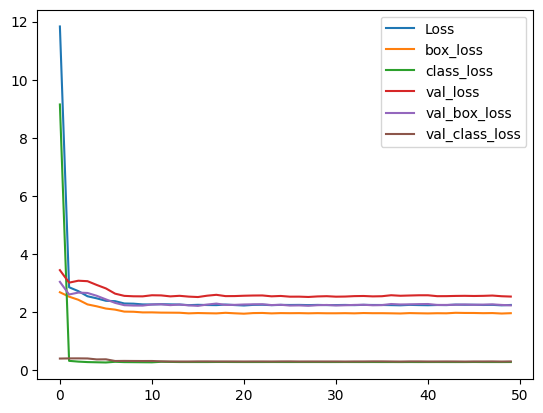

In [32]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

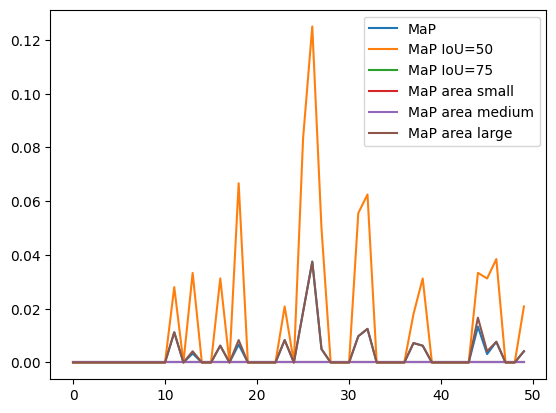

In [33]:
plt.plot(history.history['MaP'], label='MaP')
plt.plot(history.history['MaP@[IoU=50]'], label='MaP IoU=50')
plt.plot(history.history['MaP@[IoU=75]'], label='MaP IoU=75')
plt.plot(history.history['MaP@[area=small]'], label='MaP area small')
plt.plot(history.history['MaP@[area=medium]'], label='MaP area medium')
plt.plot(history.history['MaP@[area=large]'], label='MaP area large')
plt.legend(loc="upper right")
plt.show()

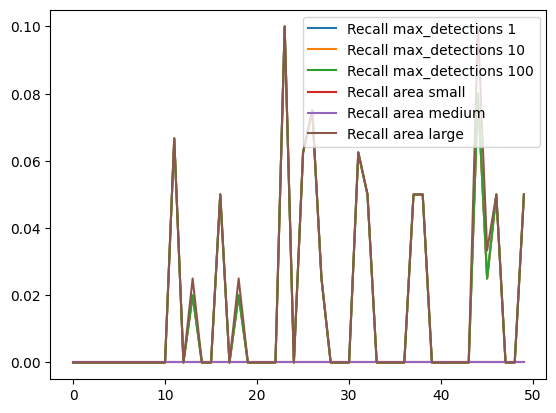

In [34]:
plt.plot(history.history['Recall@[max_detections=1]'], label='Recall max_detections 1')
plt.plot(history.history['Recall@[max_detections=10]'], label='Recall max_detections 10')
plt.plot(history.history['Recall@[max_detections=100]'], label='Recall max_detections 100')
plt.plot(history.history['Recall@[area=small]'], label='Recall area small')
plt.plot(history.history['Recall@[area=medium]'], label='Recall area medium')
plt.plot(history.history['Recall@[area=large]'], label='Recall area large')
plt.legend(loc="upper right")
plt.show()

In [35]:
now = datetime.datetime.now()
pd.DataFrame.from_dict(history.history).to_csv(HISTORY_NAME + now.strftime("-%m%d%Y-%H%M%S") + '.csv',index=False)